In [1]:
using Markdown

# Monte Carlo (Concrete) Dropout: Bayesian Neural Network (BNN) for a regression task

From [https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb](https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb).
For more information on this BNN implementation, see https://arxiv.org/pdf/1703.04977.pdf

In [2]:
using Flux
using Flux.Optimise: update!
using Random
using StatsBase
using StatsPlots
using ConcreteDropoutLayer # v0.0.0
using ConcreteDropoutLayer: Split

Random.seed!(MersenneTwister(1))

Random.MersenneTwister(0xd1c5b1c2225ab8e8a94069560b4dc741)

## Data

In [3]:
function gen_data(N; in=1, out=1)
    X = randn(Float32, Q, N)
    σ = 1
    w = 2
    b = 8
    Y = w * ones(out, in) * X .+ b + σ * randn(Float32, out, N)
    return X, Y
end

gen_data (generic function with 1 method)

## Neural network functions

In [4]:
function build_model_concrete_dropout(in, out)
    DL_model = Chain(
        Dense(in => 100, relu),
        Dense(100 => 100),
        ConcreteDropout(),
        relu,
        Dense(100 => 100),
        ConcreteDropout(),
        relu
    )

    est_mean = Chain(Dense(100 => out), ConcreteDropout(), relu)
    est_logvar = Chain(Dense(100 => out), ConcreteDropout(), relu)

    return Chain(DL_model, Split(est_mean, est_logvar)) |> f32
end

function build_model_dropout(in, out, p)
    DL_model = Chain(
        Dense(in => 100, relu),
        Dense(100 => 100),
        Dropout(p),
        relu,
        Dense(100 => 100),
        Dropout(p),
        relu
    )

    est_mean = Chain(Dense(100 => out), Dropout(p), relu)
    est_logvar = Chain(Dense(100 => out), Dropout(p), relu)

    return Chain(DL_model, Split(est_mean, est_logvar)) |> f32
end

build_model_dropout (generic function with 1 method)

## Loss functions

In [5]:
function heteroscedastic_loss(y_pred, y_true)
    D = size(y_pred, 1) ÷ 2
    μ = y_pred[1:D, :]
    log_var = y_pred[D+1:end, :]
    precision = exp.(-log_var)
    return sum(precision .* (y_true - μ) .^ 2 + log_var)
end

function full_loss(model, x, y; kwargs...)
    return heteroscedastic_loss(model(x), y) + add_CD_regularization(model[1]; kwargs...) + add_CD_regularization(model[2].paths[1]; kwargs...) + add_CD_regularization(model[2].paths[2]; kwargs...)
end

function simple_loss(model, x, y)
    return heteroscedastic_loss(model(x), y)
end

simple_loss (generic function with 1 method)

## Training functions

In [6]:
function train_step!(model, opt_state, xy, func_loss)
    # Calculate the gradient of the objective
    # with respect to the parameters within the model:
    loss, grads = Flux.withgradient(model) do m
        func_loss(m, xy...)
    end
    update!(opt_state, model, grads[1])
    return loss
end

"""
    train!(model, opt, data, func_loss, x_test, y_test, epochs)
Train the `model` and comute at each epoch the training and testing loss
"""
function train!(model, opt, data, func_loss, x_test, y_test, epochs)
    v_loss = Float32[]
    t_loss = Float32[]
    loss = rand(Float32) # just to define loss in outer loop scope # probably better ways to do that
    for epoch in 1:epochs
        for d in data
            loss = train_step!(model, opt, d, func_loss)
        end
        test_loss = heteroscedastic_loss(model(x_test), y_test)
        append!(v_loss, loss)
        append!(t_loss, test_loss)
        @info "Epoch $epoch train_loss = $(round(loss, digits = 4)) test_loss = $(round(test_loss, digits = 4))"
    end
    return v_loss, model, opt, t_loss
end

Main.var"##225".train!

# Data & Settings

In [7]:
Q = 1
D = 1
n_train = 1000
n_test = 500

x_train, y_train = gen_data(n_train, in=Q, out=D)

x_test, y_test = gen_data(n_test, in=Q, out=D)

batch_size = 128
epochs = 100
data = Flux.DataLoader((x_train, y_train), batchsize=batch_size)

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float64}}, batchsize=128)
  with first element:
  (1×128 Matrix{Float32}, 1×128 Matrix{Float64},)

# Training

## Dropout Model

In [8]:
fix_dropout = 0.1
model_d = build_model_dropout(Q, D, fix_dropout)

Chain(
  Chain(
    Dense(1 => 100, relu),              # 200 parameters
    Dense(100 => 100),                  # 10_100 parameters
    Dropout(0.1),
    NNlib.relu,
    Dense(100 => 100),                  # 10_100 parameters
    Dropout(0.1),
    NNlib.relu,
  ),
  Split(
    Tuple(
      Chain(
        Dense(100 => 1),                # 101 parameters
        Dropout(0.1),
        NNlib.relu,
      ),
      Chain(
        Dense(100 => 1),                # 101 parameters
        Dropout(0.1),
        NNlib.relu,
      ),
    ),
  ),
)                   # Total: 10 arrays, 20_602 parameters, 81.539 KiB.

Initialise the optimiser for this model:

In [9]:
opt_state_d = Flux.setup(Adam(), model_d)
v_loss_d, model_out_d, opt_out_d, t_loss_d = train!(model_d, opt_state_d, data, simple_loss, x_test, y_test, epochs)

[ Info: Epoch 1 train_loss = 5579.2549 test_loss = 25372.5391
[ Info: Epoch 2 train_loss = 3791.4728 test_loss = 16667.101
[ Info: Epoch 3 train_loss = 2352.9778 test_loss = 9033.5052
[ Info: Epoch 4 train_loss = 1267.7255 test_loss = 4544.0557
[ Info: Epoch 5 train_loss = 987.3929 test_loss = 3109.641
[ Info: Epoch 6 train_loss = 1159.5683 test_loss = 2875.9987
[ Info: Epoch 7 train_loss = 941.3251 test_loss = 2797.1211
[ Info: Epoch 8 train_loss = 1031.6736 test_loss = 2638.4681
[ Info: Epoch 9 train_loss = 912.899 test_loss = 2432.2177
[ Info: Epoch 10 train_loss = 877.2073 test_loss = 2236.3303
[ Info: Epoch 11 train_loss = 673.0676 test_loss = 2062.7414
[ Info: Epoch 12 train_loss = 596.8456 test_loss = 1897.8613
[ Info: Epoch 13 train_loss = 507.7095 test_loss = 1748.8023
[ Info: Epoch 14 train_loss = 635.8075 test_loss = 1593.5754
[ Info: Epoch 15 train_loss = 488.9967 test_loss = 1475.9071
[ Info: Epoch 16 train_loss = 346.7849 test_loss = 1398.431
[ Info: Epoch 17 train_loss =

(Float32[5579.255, 3791.4727, 2352.9778, 1267.7255, 987.3929, 1159.5682, 941.3251, 1031.6736, 912.899, 877.20734  …  347.36157, 338.94385, 481.8965, 449.7856, 490.67563, 317.805, 658.3134, 330.82938, 307.58252, 442.57605], Chain(Chain(Dense(1 => 100, relu), Dense(100 => 100), Dropout(0.1), relu, Dense(100 => 100), Dropout(0.1), relu), ConcreteDropoutLayer.Split{Tuple{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dropout{Float64, Colon, Random.TaskLocalRNG}, typeof(NNlib.relu)}}, Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dropout{Float64, Colon, Random.TaskLocalRNG}, typeof(NNlib.relu)}}}}((Chain(Dense(100 => 1), Dropout(0.1), relu), Chain(Dense(100 => 1), Dropout(0.1), relu)))), (layers = ((layers = ((weight = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[3.32348; 7.83893; … ; 4.07645; 7.90406;;], Float32[623.08; 735.554; … ; 583.097; 677.173;;], (2.22967f-37, 0.448705))), bias = Leaf(Adam(0.001, (0.9

## Concrete Dropout Model

Compute the regularisation values

In [10]:
wr = get_weight_regularizer(n_train, l=1.0f-2, τ=1.0f0)
dr = get_dropout_regularizer(n_train, τ=1.0f0, cross_entropy_loss=false)

model = build_model_concrete_dropout(Q, D)
opt_state = Flux.setup(Adam(), model)
reg_loss(model, x, y) = full_loss(model, x, y; lw=wr, ld=dr)
v_loss, model_out, opt_out, t_loss = train!(model, opt_state, data, reg_loss, x_test, y_test, epochs)

[ Info: Epoch 1 train_loss = 5456.8594 test_loss = 24582.3321
[ Info: Epoch 2 train_loss = 3521.2504 test_loss = 15666.2882
[ Info: Epoch 3 train_loss = 2179.8799 test_loss = 8116.898
[ Info: Epoch 4 train_loss = 1446.801 test_loss = 4207.6791
[ Info: Epoch 5 train_loss = 1082.3161 test_loss = 3131.5056
[ Info: Epoch 6 train_loss = 1129.431 test_loss = 2979.3418
[ Info: Epoch 7 train_loss = 743.698 test_loss = 2884.7357
[ Info: Epoch 8 train_loss = 751.8617 test_loss = 2729.2516
[ Info: Epoch 9 train_loss = 736.191 test_loss = 2551.1094
[ Info: Epoch 10 train_loss = 816.5585 test_loss = 2367.999
[ Info: Epoch 11 train_loss = 578.1455 test_loss = 2189.7573
[ Info: Epoch 12 train_loss = 447.0454 test_loss = 1995.3221
[ Info: Epoch 13 train_loss = 453.7356 test_loss = 1803.9281
[ Info: Epoch 14 train_loss = 390.614 test_loss = 1624.4091
[ Info: Epoch 15 train_loss = 465.6861 test_loss = 1486.6374
[ Info: Epoch 16 train_loss = 353.2818 test_loss = 1358.6423
[ Info: Epoch 17 train_loss = 53

(Float32[5456.8594, 3521.2505, 2179.88, 1446.8009, 1082.316, 1129.431, 743.698, 751.8617, 736.191, 816.55853  …  287.93835, 317.61957, 320.2186, 291.11502, 343.52692, 255.7725, 311.34296, 322.8286, 276.00693, 330.81683], Chain(Chain(Dense(1 => 100, relu), Dense(100 => 100), ConcreteDropout(0.0751), relu, Dense(100 => 100), ConcreteDropout(0.0717), relu), ConcreteDropoutLayer.Split{Tuple{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, ConcreteDropoutLayer.ConcreteDropout{Vector{Float32}, Colon, Random.TaskLocalRNG}, typeof(NNlib.relu)}}, Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, ConcreteDropoutLayer.ConcreteDropout{Vector{Float32}, Colon, Random.TaskLocalRNG}, typeof(NNlib.relu)}}}}((Chain(Dense(100 => 1), ConcreteDropout(0.056), relu), Chain(Dense(100 => 1), ConcreteDropout(0.0843), relu)))), (layers = ((layers = ((weight = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[-1.12628; -0.353719; … ; 0.210946; -0.70169

# Result

## Training loss

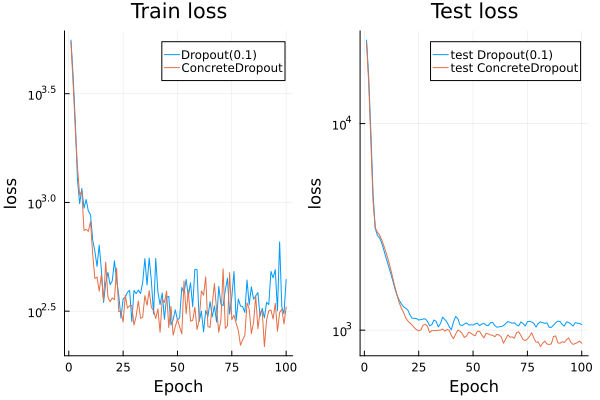

In [11]:
begin
    p_train = plot(v_loss_d, label="Dropout($fix_dropout)", title="Train loss")
    plot!(v_loss, label="ConcreteDropout")
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    p_test = plot(t_loss_d, label="test Dropout($fix_dropout)", title="Test loss")
    plot!(t_loss, label="test ConcreteDropout")
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    plot(p_train, p_test)
end

## Monte Carlo predictions

In [12]:
##! only work with D = out = 1 as it is coded now
"""
MC_predict(model, X::AbstractArray{T}; n_samples=1000, kwargs...)
For each X it returns `n_samples` monte carlo simulations where the randomness comes from the (Concrete)Dropout layers.
"""
function MC_predict(model, X::AbstractArray; n_samples=1000, heteroscedastic=true, kwargs...)
    Flux.testmode!(model, false) # (Concrete)Dropout will be active during predictions => Monte Carlo (Concrete)Dropout
    dim_out = Flux.outputsize(model, size(X))[1]
    D = heteroscedastic ? dim_out ÷ 2 : dim_out
    dim_N = ndims(X)
    mean_arr = zeros(D, size(X, dim_N))
    std_dev_arr = zeros(D, size(X, dim_N))

    X_in = similar(X, size(X)[1:end-1]..., n_samples)

    for (i, x) in enumerate(eachslice(X, dims=dim_N, drop = false))
        X_in[:] .= x

        predictions = model(X_in)
        θs_MC = predictions[1:D, :]
        logvars = predictions[D+1:end, :]

        θ_hat = mean(θs_MC, dims=2) # predictive_mean

        θ2_hat = mean(θs_MC .^ 2, dims=2)
        var_mean = mean(exp.(logvars), dims=2) # aleatoric_uncertainty
        total_var = θ2_hat - θ_hat .^ 2 + var_mean
        std_dev = sqrt.(total_var)

        mean_arr[:, i] .= θ_hat
        std_dev_arr[:, i] .= std_dev
    end
    Flux.testmode!(model) # turn back to default mode
    return mean_arr, std_dev_arr
end

y_pred, y_std = MC_predict(model_out, x_test)
y_pred_d, y_std_d = MC_predict(model_out_d, x_test)

([5.956752300262451 6.348584175109863 … 7.490677833557129 8.1840181350708], [2.869976758956909 3.1962385177612305 … 3.6650941371917725 4.258983612060547])

Plot prediction plus standard deviation (aleatoric + epistemic)

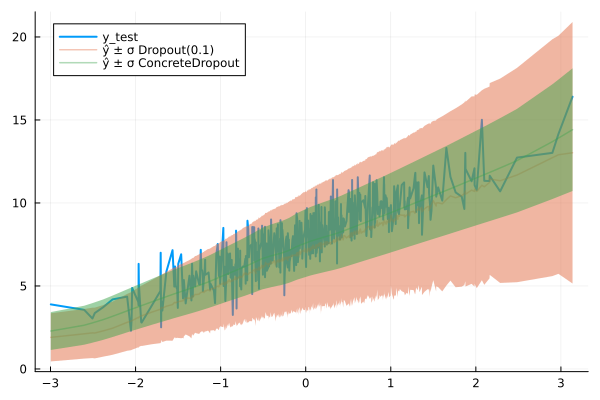

In [13]:
begin
    argsort = sortperm(x_test, dims=2)
    x_sorted = x_test[argsort]'
    y_true_sorted = y_test[argsort]'

    plot(x_sorted, y_true_sorted, label="y_test", lw = 2)
    plot!(x_sorted, y_pred_d[argsort]', ribbon=y_std_d[argsort]', label="ŷ ± σ Dropout(0.1)", alpha=0.4, lw = 1.5)
    plot!(x_sorted, y_pred[argsort]', ribbon=y_std[argsort]', label="ŷ ± σ ConcreteDropout", alpha=0.4, lw = 1.5)
end

Print all learned Dropout rates.

In [14]:
for layer in [model_out[1]...; model_out[2][1]...; model_out[2][2]...]
    if layer isa ConcreteDropout
        println(layer)
    end
end

ConcreteDropout(0.0751)
ConcreteDropout(0.0717)
ConcreteDropout(0.056)
ConcreteDropout(0.0843)


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*